TODO:
- Finish revising the grains of the main dataframes.
- Let the user select a period as a continuous range of whole days.
- Set the notebook up to ingest TOS data from CSV files.
- Incorporate documentation

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
def dwell_times(container_times, sampling_interval, first_day, last_day, print_setting, debug_setting, overlay_setting):

    def plot_segments(segments, x1, x2, y1, y2, xTitle, yTitle, plotTitle, color, show, time_start, time_end):
        # Create the plot object
        for i in range(len(segments)):
            plt.plot([segments.loc[i, x1], segments.loc[i, x2]]
                      , [segments.loc[i, y1], segments.loc[i, y2]]
                     , color=color)
        
        # Display the plot
        plt.xticks(rotation=90)
        plt.xlim(time_start, time_end)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.title(plotTitle)
        if show:
            plt.show()
        return plt

    def return_zero_for_div_by_zero(numerators, divisors):
        return [num / div if div != 0 else 0 for num, div in zip(numerators, divisors)]

    def initial_dwell(box_schedule_df_row, start_time):
        if start_time >= box_schedule_df_row['departure']:
            return(pd.Timedelta(0))
        elif start_time <= box_schedule_df_row['arrival']:
            return(pd.Timedelta(0))
        else:
            return (start_time - box_schedule_df_row['arrival'])

    # The users can input a time table of arrivals and departures for containers. The users can also
    # select dates that they are interested in. This is so that we can eventually supply a list of
    # all the containers that were on the terminal for those dates and report metrics only for those
    # dates instead of from the earliest event to the latest.

    # The integration method needs a dataframe with a grain of one row per interval between inventory
    # change events per day. If an interval stretches over two or more days, then it needs to be split.

    # The sampling method needs a dataframe with a grain of one row per sample.

    # The ratio method needs a dataframe with a grain of one row per container per day.

    # The mainsail method needs a dataframe with a grain of one row per container. Selection of rows will
    # be used to get individual days.

    # Let's setup the user-input data.

    container_times_df = pd.DataFrame(container_times)
    if debug_setting:
        print(container_times_df)
    container_times_df['arrival'] = container_times_df['arrival'].apply(lambda x: pd.to_datetime(x))
    container_times_df['departure'] = container_times_df['departure'].apply(lambda x: pd.to_datetime(x))
    container_times_df['dwell'] = container_times_df['departure'] - container_times_df['arrival']

    # And the rest of the user input
    sampling_timedelta = pd.Timedelta(hours=3)
    start_time = pd.to_datetime(first_day)
    end_time = pd.to_datetime(last_day) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    if debug_setting:
        print('start_time: ', start_time)
        print('end_time: ', end_time)
    first_day = start_time.date()
    last_day = end_time.date()
    date_df = pd.DataFrame(pd.date_range(start=first_day, end=last_day), columns=['day_actual'])
    date_df['day_actual'] = date_df['day_actual'].apply(lambda x: x.date())
    period = end_time - start_time

    # To create the integration dataframe with a grain of one row per interval between inventory change
    # events per day, I need to create an event list and then join it to itself, shifting by one row,
    # to get intervals.

    # Building the integration dataframe first is a good choice. We'll use it to produce the plots too.

    # Let's unpivot the input time table to get arrival and departure events.
    integration_df = pd.melt(
        pd.DataFrame(container_times_df)
        , id_vars=['container']
        , value_vars=['arrival', 'departure']
        , var_name='event_type'
        , value_name='event_time'
    )
    integration_df = integration_df.sort_values(by='event_time', ascending=True)
    integration_df['box_count_incr'] = (
        integration_df['event_type'].apply(lambda x: 1 if x == 'arrival' else -1)
    )
    integration_df['box_count'] = integration_df['box_count_incr'].cumsum()
    integration_df['event_start_day'] = pd.to_datetime(integration_df['event_time']).apply(lambda x: x.date())
    integration_df['next_container'] = integration_df['container'].shift(-1)
    integration_df['next_event_type'] = integration_df['event_type'].shift(-1)
    integration_df['next_event_time'] = integration_df['event_time'].shift(-1)
    integration_df['event_end_day'] = pd.to_datetime(integration_df['next_event_time'].apply(lambda x: x.date()))
    # At this point, let's split the intervals by day.
    conn = sqlite3.connect(':memory:')
    integration_df.to_sql('integration_df', conn, index=False)
    date_df.to_sql('date_df', conn, index=False)
    query = '''
        select *
        from integration_df
        inner join date_df on
            date_df.day_actual between integration_df.event_start_day and integration_df.event_end_day
    '''
    integration_df = pd.read_sql_query(query, conn)
    integration_df['event_time'] = integration_df['event_time'].apply(lambda x: pd.to_datetime(x))
    integration_df['event_start_day'] = integration_df['event_start_day'].apply(lambda x: pd.to_datetime(x))
    integration_df['next_event_time'] = integration_df['next_event_time'].apply(lambda x: pd.to_datetime(x))
    integration_df['event_end_day'] = integration_df['event_end_day'].apply(lambda x: pd.to_datetime(x))
    integration_df['day_actual'] = integration_df['day_actual'].apply(lambda x: pd.to_datetime(x))
    integration_df['interval_start_time'] = np.maximum(integration_df['event_time'], integration_df['day_actual'])
    integration_df['interval_end_time'] = np.minimum(integration_df['next_event_time'], integration_df['day_actual'] + pd.Timedelta(days=1))
    integration_df['duration'] = integration_df['interval_end_time'] - integration_df['interval_start_time']
    # The dwell_rise is the amount of dwell time gained during the intervals. It's the product of the box count and the duration.
    integration_df['dwell_rise'] = integration_df['duration'] * integration_df['box_count']
    # Here I need to merge the container_times_df so that I can get the dwell for each container for the entire visit.
    # I need the dwell for each container for the entire visit so that I can subtract the dwell time out of the cumulative sum
    # when the container departs.
    integration_df = pd.merge(integration_df, container_times_df, on='container', how='inner')
    integration_df['dwell_loss'] = (
        integration_df.apply(
            lambda row: -1 * row['dwell']
                if (row['event_type'] == 'departure') & (row['event_start_day'] == row['day_actual'])
                else pd.to_timedelta(0)
            , axis=1
        )
    )
    # The dwell time increment for the interval is the sum of the dwell_rise and the dwell_loss.
    integration_df['dwell_incr'] = integration_df['dwell_rise'] + integration_df['dwell_loss']
    # The cumulative sum is a handy way to get the total dwell at the end of the interval.
    # Since we don't start with an empty yard, we need to add the initial total dwell.
    container_times_df['initial_dwell'] = container_times_df.apply(lambda row: initial_dwell(row, start_time), axis=1)
    initial_total_dwell = container_times_df['initial_dwell'].sum()
    if debug_setting:
        print('integration_df:\n', integration_df, '\n')
        print('initial_total_dwell:\n', initial_total_dwell, '\n')
    integration_df['ending_dwell'] = integration_df['dwell_incr'].cumsum() + initial_total_dwell
    # And the starting dwell can be obtained easily enough be subtracting the dwell_rise.
    integration_df['starting_dwell'] = integration_df['ending_dwell'] - integration_df['dwell_rise']
    # The average dwell at the end points of the interval can be computed from the total dwell 
    # by dividing by the box count.
    integration_df['starting_avg_dwell'] = integration_df['starting_dwell'] / integration_df['box_count']
    integration_df['starting_avg_dwell'] = integration_df['starting_avg_dwell'].apply(lambda x: x.total_seconds() / 3600)
    integration_df['ending_avg_dwell'] = integration_df['ending_dwell'] / integration_df['box_count']
    integration_df['ending_avg_dwell'] = integration_df['ending_avg_dwell'].apply(lambda x: x.total_seconds() / 3600)
    integration_df['avg_dwell_rise'] = integration_df['ending_avg_dwell'] - integration_df['starting_avg_dwell']

    # Let's produce the plots now.
    segments = integration_df.copy()
    segments = segments.drop(columns=[
                        'container','event_type','box_count_incr'
                        ,'next_container','next_event_type','duration','dwell_rise'
                        ,'arrival','departure','dwell','dwell_loss'
                        ,'dwell_incr','day_actual'
                        ,'event_time','event_start_day','next_event_time','event_end_day'])
    segments['starting_dwell'] = segments['starting_dwell'].apply(lambda x: x.total_seconds())/3600
    segments['ending_dwell'] = segments['ending_dwell'].apply(lambda x: x.total_seconds())/3600

    if print_setting:
        # Total dwell time plot
        plot_segments(segments, 'interval_start_time', 'interval_end_time', 'starting_dwell', 'ending_dwell',
                      'Time', 'Total Dwell (hours)', 'Total Dwell Time Over Time', '#36454F', True, start_time, end_time)
    
        # Box count plot
        plot_segments(segments, 'interval_start_time', 'interval_end_time', 'box_count', 'box_count',
                      'Time', 'Container Count', 'Container Count Over Time', '#36454F', True, start_time, end_time)
        #print('avg box count:\n', segments['box_count'].mean())

    # Let's produce the sampling times and sampled avg dwells for overlay on the avg dwell plot next.
    # The sample_offset let's us sample in the middle of the interval instead of at the beginning.
    sample_offset = sampling_timedelta / 2
    sampling_times = pd.date_range(start=(start_time + sample_offset), end=end_time, freq=sampling_timedelta)
    sampling_df = pd.DataFrame(sampling_times, columns=['sampling_time'])
    # Joining the samples to the segments
    sampling_df.to_sql('sampling_df', conn, index=False)
    if debug_setting:
        print('segments:\n', segments, '\n')
    segments.to_sql('segments', conn, index=False)
    query = '''
        select *
        from sampling_df
        left join segments on
            sampling_df.sampling_time between segments.interval_start_time and segments.interval_end_time
    '''
    sampling_df = pd.read_sql_query(query, conn)
    # Use linear interpolation to obtain the sampled avg dwell time
    sampling_df['sample_dwell'] = (
        sampling_df['starting_avg_dwell'] +
        (sampling_df['sampling_time'].apply(pd.to_datetime) -
         sampling_df['interval_start_time'].apply(pd.to_datetime)).apply(lambda x: x.total_seconds() / 3600)
    )
    sampling_df['sampling_time'] = pd.to_datetime(sampling_df['sampling_time'])
    # If there's no data, let the sample be 0.
    sampling_df['sample_dwell'] = sampling_df['sample_dwell'].fillna(0)
    
    # Avg dwell time plot
    if print_setting:
        avg_dwell_plot = plot_segments(segments, 'interval_start_time', 'interval_end_time', 'starting_avg_dwell', 'ending_avg_dwell',
                      'Time', 'Avg Dwell (hours)', 'Avg Dwell Time Over Time and Sampled Points', '#36454F', False, start_time, end_time)
        if overlay_setting:
            avg_dwell_plot.scatter(sampling_df['sampling_time'], sampling_df['sample_dwell'], color='#36454F', label='Sampling Points')
        else:
            avg_dwell_plot.show()

    ## Now time to compute results
    # results_df = pd.DataFrame(columns=['Method', 'Timeframe', 'Value'])
    
    # Integration results
    integration_df['duration_hours'] = integration_df['duration'].apply(lambda x: x.total_seconds())/3600
    integration_df['area'] = (
        integration_df['starting_avg_dwell'] * integration_df['duration_hours']
            + 0.5 * integration_df['duration_hours'] * integration_df['avg_dwell_rise']
        # Need avg_dwell_rise here because if there are not boxes, it's zero.
    )
    if debug_setting:
        with pd.option_context('display.max_columns', None):
            print('integration_df:\n')
            print(integration_df)
    integration_result_all = round(integration_df['area'].sum() / ((end_time - start_time).total_seconds()/3600), 1)
    
    daily_integration_results = integration_df.groupby('day_actual')['area'].sum().reset_index()
    daily_integration_results['avg_dwell'] = round(daily_integration_results['area']/24.0, 1)
    daily_integration_results['Method'] = 'Integration'
    daily_integration_results['Timeframe'] = daily_integration_results['day_actual'].apply(lambda x: x.date())
    daily_integration_results['Avg Dwell'] = daily_integration_results['avg_dwell']
    daily_integration_results = daily_integration_results.drop(columns=['day_actual', 'avg_dwell', 'area'])
    
    integration_result_avg = daily_integration_results['Avg Dwell'].mean()
    
    results_df = pd.DataFrame([{'Method': 'Integration', 'Timeframe': 'Entire Period', 'Avg Dwell': integration_result_all}])
    results_df = pd.concat([results_df, daily_integration_results], ignore_index = True)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Integration'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': integration_result_avg
         }])]
        , ignore_index = True
    )
        
    # Sampling results
    sampling_result = round(sampling_df['sample_dwell'].mean(), 1)
    
    sampling_df['day_actual'] = sampling_df['sampling_time'].apply(lambda x: x.date())
    daily_sampling_results = sampling_df.groupby('day_actual')['sample_dwell'].mean().reset_index()
    daily_sampling_results = daily_sampling_results.rename(columns={'day_actual': 'Timeframe', 'sample_dwell': 'Avg Dwell'})
    daily_sampling_results['Avg Dwell'] = round(daily_sampling_results['Avg Dwell'], 1)
    daily_sampling_results['Method'] = 'Sampling'
    
    daily_sampling_avg = round(daily_sampling_results['Avg Dwell'].mean(), 1)

    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Sampling'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': sampling_result
         }])]
        , ignore_index = True
    )
    results_df = pd.concat([results_df, daily_sampling_results], ignore_index = True)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Sampling'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_sampling_avg
         }])]
        , ignore_index = True
    )
    
    # Ratio results
    # The ratio method needs a dataframe with a grain of one row per container per day.
    ratio_df = container_times_df.copy()
    ratio_df['initial_dwell'] = ratio_df['initial_dwell'].apply(lambda x: x.total_seconds())/3600
    ratio_df['dwell'] = ratio_df['dwell'].apply(lambda x: x.total_seconds())/3600
    ratio_df['dwell_start_day'] = ratio_df['arrival'].apply(lambda x: x.date())
    ratio_df['dwell_end_day'] = ratio_df['departure'].apply(lambda x: x.date())
    if debug_setting:
        print('ratio_df:\n', ratio_df)
    ratio_df.to_sql('ratio_df', conn, index=False)
    query = '''
        select ratio_df.*, date(date_df.day_actual) as day_actual
        from ratio_df
        inner join date_df on date(date_df.day_actual) between ratio_df.dwell_start_day and ratio_df.dwell_end_day
    '''
    ratio_df = pd.read_sql_query(query, conn)
    ratio_df['arrival'] = ratio_df['arrival'].apply(lambda x: pd.to_datetime(x))
    ratio_df['departure'] = ratio_df['departure'].apply(lambda x: pd.to_datetime(x))
    ratio_df['dwell'] = round(ratio_df['dwell'], 1)
    ratio_df['dwell_start_day'] = ratio_df['dwell_start_day'].apply(lambda x: pd.to_datetime(x).date())
    ratio_df['dwell_end_day'] = ratio_df['dwell_end_day'].apply(lambda x: pd.to_datetime(x).date())
    ratio_df['day_actual'] = ratio_df['day_actual'].apply(lambda x: pd.to_datetime(x))
    ratio_df['end_of_day_actual'] = ratio_df['day_actual'] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    ratio_df['daily_duration_start'] = ratio_df[['arrival', 'day_actual']].max(axis=1)
    ratio_df['daily_duration_end'] = ratio_df[['departure', 'end_of_day_actual']].min(axis=1)
    ratio_df['daily_initial_dwell'] = ratio_df['daily_duration_start'] - ratio_df['arrival']
    ratio_df['daily_box_duration'] = ratio_df['daily_duration_end'] - ratio_df['daily_duration_start']
    ratio_df['daily_avg_dwell'] = ratio_df['daily_initial_dwell'] + ratio_df['daily_box_duration']/2
    ratio_df['daily_avg_dwell'] = round(ratio_df['daily_avg_dwell'].apply(lambda x: x.total_seconds()/3600), 1)
    ratio_df['daily_box_duration'] = round(ratio_df['daily_box_duration'].apply(lambda x: x.total_seconds()/3600), 1)
    ratio_df['daily_box_dwell_areas'] = ratio_df['daily_avg_dwell'] * ratio_df['daily_box_duration']
    if debug_setting:
        print('ratio_df:\n', ratio_df)

    ratio_result = round(ratio_df['daily_box_dwell_areas'].sum() / ratio_df['daily_box_duration'].sum(), 1)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Ratio'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': ratio_result
         }])]
        , ignore_index = True
    )

    daily_ratio_results = ratio_df.groupby('day_actual').agg({'daily_box_dwell_areas': 'sum', 'daily_box_duration': 'sum'}).reset_index()  
    daily_ratio_results['Avg Dwell'] = daily_ratio_results['daily_box_dwell_areas'] / daily_ratio_results['daily_box_duration']
    daily_ratio_results = daily_ratio_results.drop(columns=['daily_box_dwell_areas', 'daily_box_duration'])
    daily_ratio_results = daily_ratio_results.rename(columns={'day_actual': 'Timeframe'})
    daily_ratio_results['Method'] = 'Ratio'
    daily_ratio_results['Timeframe'] = daily_ratio_results['Timeframe'].apply(lambda x: x.date())
    if debug_setting:
        print('daily_ratio_results:\n', daily_ratio_results)
    results_df = pd.concat([results_df, daily_ratio_results], ignore_index = True)
    
    daily_ratio_avg = round(daily_ratio_results['Avg Dwell'].mean(), 1)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Ratio'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_ratio_avg
         }])]
        , ignore_index = True
    )

    # Mainsail metric computations
    mainsail_df = container_times_df.copy()
    # Mainsail truncates the arrivals and departures to compute the dwell
    mainsail_df['arrival'] = mainsail_df['arrival'].apply(lambda x: x.normalize())
    mainsail_df['departure'] = mainsail_df['departure'].apply(lambda x: x.normalize())
    mainsail_df['dwell'] = mainsail_df['departure'] - mainsail_df['arrival']
    if debug_setting:
        print('mainsail_df:\n', mainsail_df)
    mainsail_df = (
        mainsail_df[
            (mainsail_df['arrival'] >= start_time)
            & (mainsail_df['departure'] <= end_time)
        ]
    )
    if debug_setting:
        print('mainsail_df:\n', mainsail_df)
        print('mainsail total dwell = ', mainsail_df['dwell'].apply(lambda x: x.total_seconds()/86400).sum())
        print('mainsail box count = ', len(mainsail_df))
    mainsail_result = mainsail_df['dwell'].mean().total_seconds()/3600
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Mainsail'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': mainsail_result
         }])]
        , ignore_index = True
    )

    mainsail_df = (
        mainsail_df[
            (mainsail_df['arrival'].apply(lambda x: x.date()) == mainsail_df['departure'].apply(lambda x: x.date()))
            & (mainsail_df['arrival'] >= start_time)
            & (mainsail_df['departure'] <= end_time)
        ]
    )
    mainsail_df['day_actual'] = mainsail_df['arrival'].apply(lambda x: x.date())
    mainsail_daily_results = mainsail_df.groupby('day_actual')['dwell'].mean().reset_index()
    # I want missed days to be zero.
    mainsail_daily_results = date_df.merge(mainsail_daily_results, on='day_actual', how='left')
    mainsail_daily_results['dwell'] = mainsail_daily_results['dwell'].fillna(pd.Timedelta(0))
    mainsail_daily_results = mainsail_daily_results.rename(columns={'day_actual': 'Timeframe', 'dwell': 'Avg Dwell'})
    mainsail_daily_results['Method'] = 'Mainsail'
    mainsail_daily_results['Avg Dwell'] = round(mainsail_daily_results['Avg Dwell'].apply(lambda x: x.total_seconds()/3600), 1)
    results_df = pd.concat([results_df, mainsail_daily_results], ignore_index = True)
    if debug_setting:
        print('mainsail_daily_results:\n', mainsail_daily_results)
    daily_mainsail_avg = round(mainsail_daily_results['Avg Dwell'].mean(), 1)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Mainsail'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_mainsail_avg
         }])]
        , ignore_index = True
    )
    
    if debug_setting:
        print('mainsail_daily_results:\n', mainsail_daily_results)
    
    return(results_df)

In [3]:
def fetch(df, method, timeframe, timeframe_is_date):
    if timeframe_is_date:
        return_value = (
            df.loc[
                (df['Method'] == method)
                & (df['Timeframe'] == pd.to_datetime(timeframe).date())
                , 'Avg Dwell'
            ].values[0]
        )
    else:
        return_value = (
            df.loc[
                (df['Method'] == method)
                & (df['Timeframe'] == timeframe)
                , 'Avg Dwell'
            ].values[0]
        )
    return(return_value)

In [4]:
def compose_test_result(method, timeframe, correct_value, actual_value):
    test_passes = (correct_value == actual_value)
    if test_passes:
        pass_fail_string = ' Passes'
    else:
        pass_fail_string = ' Fails'
    test_result_string = (
        pass_fail_string + ': ' 
        + 'Correct: ' + str(correct_value) 
        + '\tObtained: ' + str(actual_value) 
        + '\t' + method + ' ' + timeframe
    )
    return(test_passes, test_result_string)

In [5]:
def test(df, method, timeframe, is_date, correct_value):
    test_value = fetch(df, method, timeframe, is_date)
    (test_bool, test_string) = compose_test_result(method, timeframe, correct_value, test_value)
    return(test_bool, test_string)

In [6]:
def test_general(test_name, box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting):
    if debug_setting:
        print('\n' + test_name + ' begin\n')
        print('sample_gap: ' + str(sample_gap))
        print('first_day: ' + first_day)
        print('last_day: ' + last_day)
    results = dwell_times(box_schedules, sample_gap, first_day, last_day, print_setting, debug_setting, overlay_setting)
    if debug_setting:
        print('results:')
        print(results)
        print('\n')
    num_tests = len(tests)
    test_results = [None] * num_tests
    test_strings = [None] * num_tests
    for i in range(num_tests):
        (test_results[i], test_strings[i]) = test(results, tests[i][0], tests[i][1], tests[i][2], tests[i][3])
    test_result = all(test_results)
    if debug_setting:
        for test_string in test_strings:
            print(test_string)
        print(str(test_result) + ': ' + test_name)
    return(test_result)

In [7]:
def test_primary(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
        'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 22.0],
        ['Integration', '2024-09-01', True, 9.0],
        ['Integration', '2024-09-02', True, 21.0],
        ['Integration', '2024-09-03', True, 36.0],
        ['Integration', 'Avg Over Days', False, 22.0],
        ['Sampling', 'Entire Period', False, 22.0],
        ['Sampling', '2024-09-01', True, 9.0],
        ['Sampling', '2024-09-02', True, 21.0],
        ['Sampling', '2024-09-03', True, 36.0],
        ['Sampling', 'Avg Over Days', False, 22.0],
        ['Ratio', 'Entire Period', False, 20.4],
        ['Ratio', '2024-09-01', True, 10.0],
        ['Ratio', '2024-09-02', True, 20.4],
        ['Ratio', '2024-09-03', True, 36.0],
        ['Ratio', 'Avg Over Days', False, 22.1],
        ['Mainsail', 'Entire Period', False, 32.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_primary', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [8]:
def test_primary_first_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
        'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-02'
    tests = [
        ['Integration', 'Entire Period', False, 15.0],
        ['Integration', '2024-09-01', True, 9.0],
        ['Integration', '2024-09-02', True, 21.0],
        ['Integration', 'Avg Over Days', False, 15.0],
        ['Sampling', 'Entire Period', False, 15.0],
        ['Sampling', '2024-09-01', True, 9.0],
        ['Sampling', '2024-09-02', True, 21.0],
        ['Sampling', 'Avg Over Days', False, 15.0],
        ['Ratio', 'Entire Period', False, 16.5],
        ['Ratio', '2024-09-01', True, 10.0],
        ['Ratio', '2024-09-02', True, 20.4],
        ['Ratio', 'Avg Over Days', False, 15.2],
        ['Mainsail', 'Entire Period', False, 24.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_primary_first_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [9]:
def test_primary_last_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
        'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-02'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 28.5],
        ['Integration', '2024-09-02', True, 21.0],
        ['Integration', '2024-09-03', True, 36.0],
        ['Integration', 'Avg Over Days', False, 28.5],
        ['Sampling', 'Entire Period', False, 28.5],
        ['Sampling', '2024-09-02', True, 21.0],
        ['Sampling', '2024-09-03', True, 36.0],
        ['Sampling', 'Avg Over Days', False, 28.5],
        ['Ratio', 'Entire Period', False, 24.9],
        ['Ratio', '2024-09-02', True, 20.4],
        ['Ratio', '2024-09-03', True, 36],
        ['Ratio', 'Avg Over Days', False, 28.2],
        ['Mainsail', 'Entire Period', False, 24.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_primary_last_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [10]:
def test_some_no_inventory(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-02 12:00:00', '2024-09-03 12:00:00'],
        'departure': ['2024-09-01 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 3.0],
        ['Integration', '2024-09-01', True, 3.0],
        ['Integration', '2024-09-02', True, 3.0],
        ['Integration', '2024-09-03', True, 3.0],
        ['Integration', 'Avg Over Days', False, 3.0],
        ['Sampling', 'Entire Period', False, 3.0],
        ['Sampling', '2024-09-01', True, 3.0],
        ['Sampling', '2024-09-02', True, 3.0],
        ['Sampling', '2024-09-03', True, 3.0],
        ['Sampling', 'Avg Over Days', False, 3.0],
        ['Ratio', 'Entire Period', False, 6.0],
        ['Ratio', '2024-09-01', True, 6.0],
        ['Ratio', '2024-09-02', True, 6.0],
        ['Ratio', '2024-09-03', True, 6.0],
        ['Ratio', 'Avg Over Days', False, 6.0],
        ['Mainsail', 'Entire Period', False, 8.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_some_no_inventory', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [11]:
def test_no_starting_inventory(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 03:00:00', '2024-09-02 12:00:00', '2024-09-03 12:00:00'],
        'departure': ['2024-09-01 15:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 3.0],
        ['Integration', '2024-09-01', True, 3.0],
        ['Integration', '2024-09-02', True, 3.0],
        ['Integration', '2024-09-03', True, 3.0],
        ['Integration', 'Avg Over Days', False, 3.0],
        ['Sampling', 'Entire Period', False, 3.0],
        ['Sampling', '2024-09-01', True, 3.0],
        ['Sampling', '2024-09-02', True, 3.0],
        ['Sampling', '2024-09-03', True, 3.0],
        ['Sampling', 'Avg Over Days', False, 3.0],
        ['Ratio', 'Entire Period', False, 6.0],
        ['Ratio', '2024-09-01', True, 6.0],
        ['Ratio', '2024-09-02', True, 6.0],
        ['Ratio', '2024-09-03', True, 6.0],
        ['Ratio', 'Avg Over Days', False, 6.0],
        ['Mainsail', 'Entire Period', False, 8.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_starting_inventory', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [12]:
def test_no_ending_inventory(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-02 12:00:00', '2024-09-03 09:00:00'],
        'departure': ['2024-09-01 12:00:00', '2024-09-03 00:00:00', '2024-09-03 21:00:00']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 3.0],
        ['Integration', '2024-09-01', True, 3.0],
        ['Integration', '2024-09-02', True, 3.0],
        ['Integration', '2024-09-03', True, 3.0],
        ['Integration', 'Avg Over Days', False, 3.0],
        ['Sampling', 'Entire Period', False, 3.0],
        ['Sampling', '2024-09-01', True, 3.0],
        ['Sampling', '2024-09-02', True, 3.0],
        ['Sampling', '2024-09-03', True, 3.0],
        ['Sampling', 'Avg Over Days', False, 3.0],
        ['Ratio', 'Entire Period', False, 6.0],
        ['Ratio', '2024-09-01', True, 6.0],
        ['Ratio', '2024-09-02', True, 6.0],
        ['Ratio', '2024-09-03', True, 6.0],
        ['Ratio', 'Avg Over Days', False, 6.0],
        ['Mainsail', 'Entire Period', False, 8.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_ending_inventory', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [13]:
def test_no_inventory_first_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 03:00:00', '2024-09-02 09:00:00', '2024-09-03 09:00:00'],
        'departure': ['2024-09-01 15:00:00', '2024-09-02 21:00:00', '2024-09-03 21:00:00']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-02'
    tests = [
        ['Integration', 'Entire Period', False, 3.0],
        ['Integration', '2024-09-01', True, 3.0],
        ['Integration', '2024-09-02', True, 3.0],
        ['Integration', 'Avg Over Days', False, 3.0],
        ['Sampling', 'Entire Period', False, 3.0],
        ['Sampling', '2024-09-01', True, 3.0],
        ['Sampling', '2024-09-02', True, 3.0],
        ['Sampling', 'Avg Over Days', False, 3.0],
        ['Ratio', 'Entire Period', False, 6.0],
        ['Ratio', '2024-09-01', True, 6.0],
        ['Ratio', '2024-09-02', True, 6.0],
        ['Ratio', 'Avg Over Days', False, 6.0],
        ['Mainsail', 'Entire Period', False, 0.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_inventory_first_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [14]:
def test_no_inventory_last_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 03:00:00', '2024-09-02 09:00:00', '2024-09-03 09:00:00'],
        'departure': ['2024-09-01 15:00:00', '2024-09-02 21:00:00', '2024-09-03 21:00:00']
    }
    sample_gap = 3
    first_day = '2024-09-02'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 3.0],
        ['Integration', '2024-09-02', True, 3.0],
        ['Integration', '2024-09-03', True, 3.0],
        ['Integration', 'Avg Over Days', False, 3.0],
        ['Sampling', 'Entire Period', False, 3.0],
        ['Sampling', '2024-09-02', True, 3.0],
        ['Sampling', '2024-09-03', True, 3.0],
        ['Sampling', 'Avg Over Days', False, 3.0],
        ['Ratio', 'Entire Period', False, 6.0],
        ['Ratio', '2024-09-02', True, 6.0],
        ['Ratio', '2024-09-03', True, 6.0],
        ['Ratio', 'Avg Over Days', False, 6.0],
        ['Mainsail', 'Entire Period', False, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_inventory_last_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [15]:
print(str(test_primary(False, False, False))+ ' test_primary')
print(str(test_primary_first_two_days(False, False, False)) + ' test_primary_first_two_days')
print(str(test_primary_last_two_days(False, False, False)) + ' test_primary_last_two_days')
print(str(test_some_no_inventory(False, False, False)) + ' test_some_no_inventory')
print(str(test_no_starting_inventory(False, False, False)) + ' test_no_starting_inventory')
print(str(test_no_ending_inventory(False, False, False)) + ' test_no_ending_inventory')
print(str(test_no_inventory_first_two_days(False, False, False)) + ' test_no_inventory_first_two_days')
print(str(test_no_inventory_last_two_days(False, False, False)) + ' test_no_inventory_last_two_days')

True test_primary
True test_primary_first_two_days
True test_primary_last_two_days
True test_some_no_inventory
True test_no_starting_inventory
True test_no_ending_inventory
True test_no_inventory_first_two_days
True test_no_inventory_last_two_days


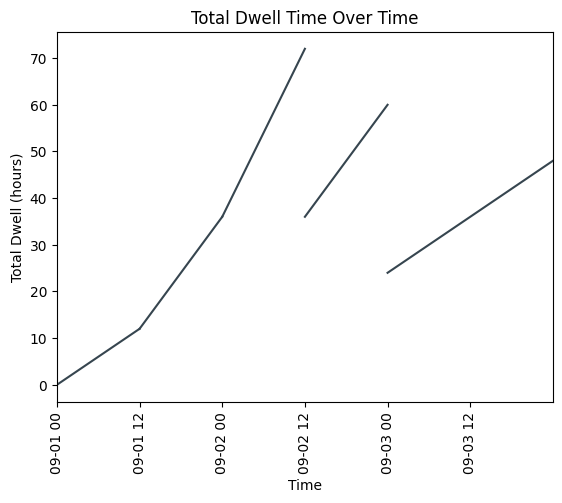

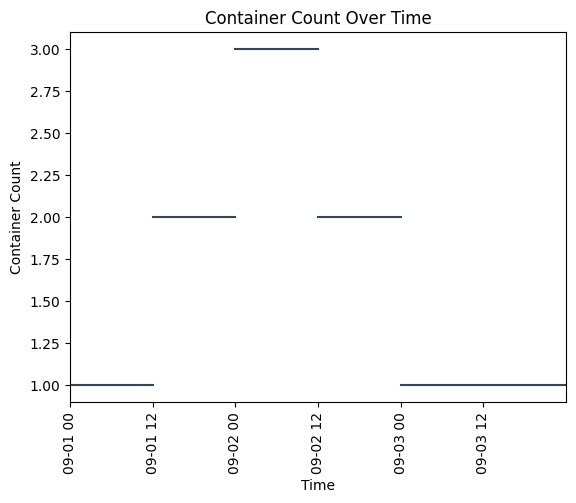

True

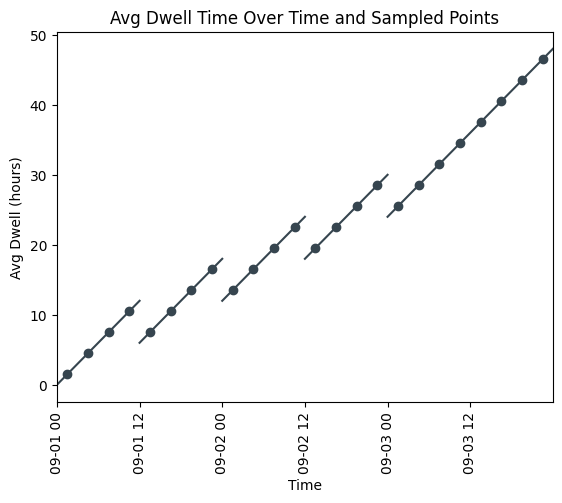

In [16]:
test_primary(True, False, True)

In [17]:
yrd120r_data = pd.read_csv('C:\\Users\\bjohnso\\OneDrive - Tideworks Technology\\YRD120R.csv', dtype=str)
sampling_interval = 12.0
first_day = '2024-09-29'
last_day = '2024-11-09'
print_setting = True
debug_setting = False
overlay_setting = False

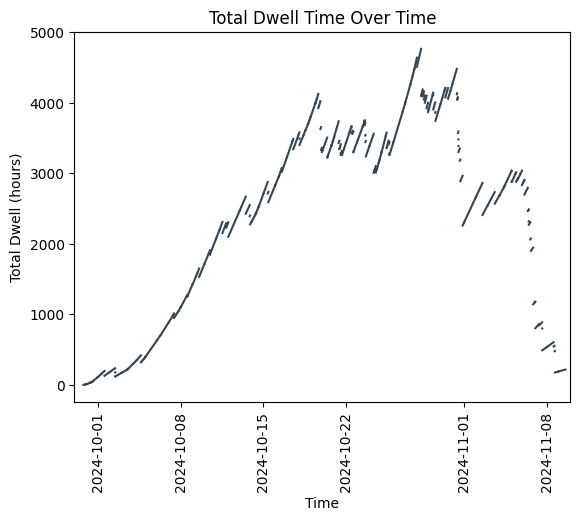

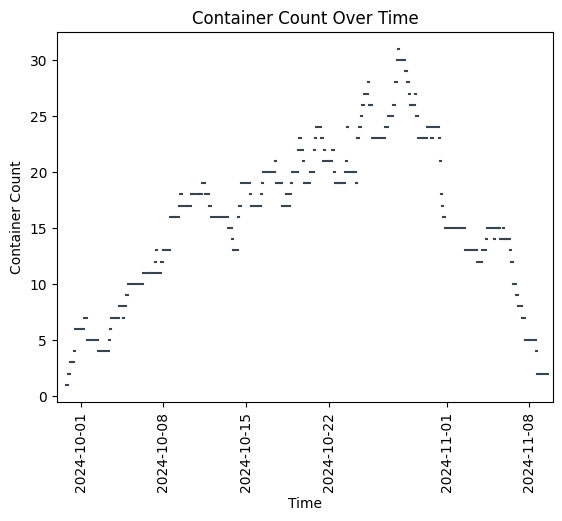

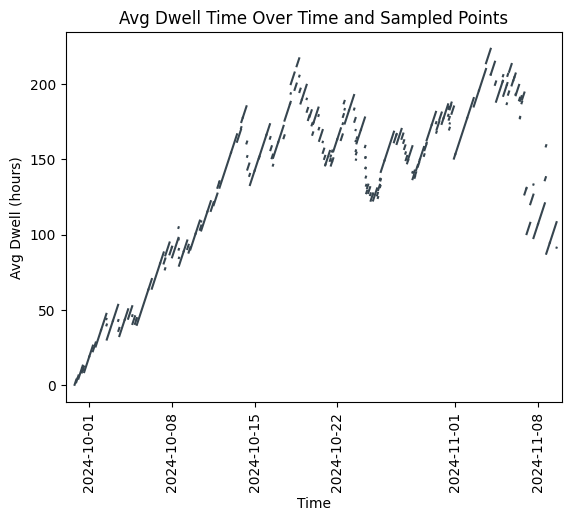

In [23]:
yrd120r_results = dwell_times(
    yrd120r_data.sample(n=100),
    sampling_interval, first_day, last_day,
    print_setting, debug_setting, overlay_setting
)

In [24]:
yrd120r_results.pivot_table(index='Method', columns='Timeframe', values='Avg Dwell')[['Avg Over Days', 'Entire Period']]

Timeframe,Avg Over Days,Entire Period
Method,,
Integration,130.559524,130.60
Mainsail,0.000000,153.36
Ratio,131.500000,148.80
Sampling,130.900000,130.90


In [20]:
crows_nest_data = pd.read_csv('C:\\Users\\bjohnso\\OneDrive - Tideworks Technology\\crows_nest_t18_yard.csv', dtype=str)
sampling_interval = 12.0
first_day = '2024-09-29'
last_day = '2024-11-09'
print_setting = True
debug_setting = False
overlay_setting = False

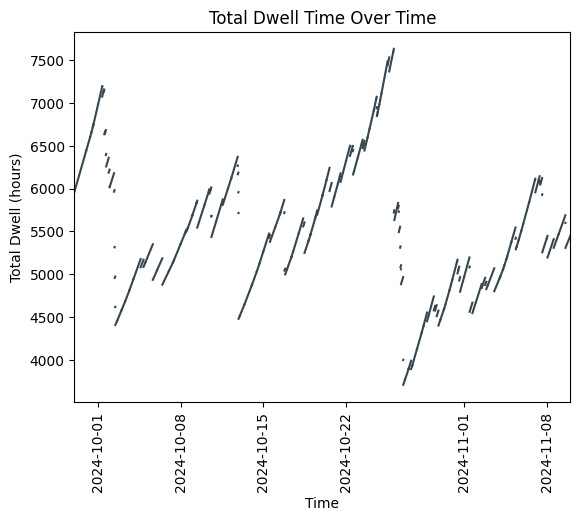

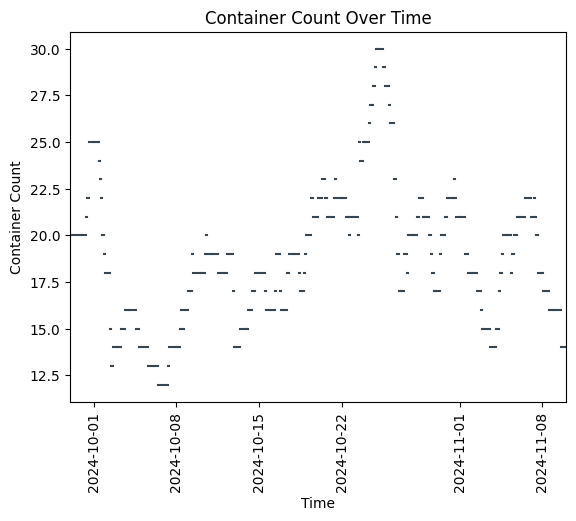

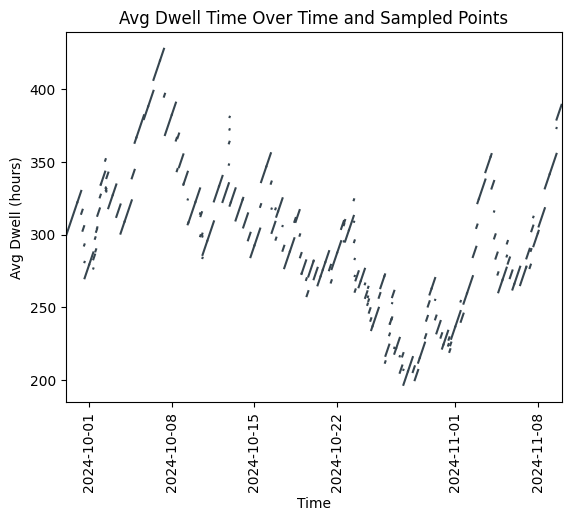

In [25]:
crows_nest_results = dwell_times(
    crows_nest_data.sample(n=100),
    sampling_interval, first_day, last_day,
    print_setting, debug_setting, overlay_setting
)

In [26]:
crows_nest_results.pivot_table(index='Method', columns='Timeframe', values='Avg Dwell')[['Avg Over Days', 'Entire Period']]

Timeframe,Avg Over Days,Entire Period
Method,,
Integration,298.8,298.800000
Mainsail,0.0,147.940299
Ratio,298.1,292.200000
Sampling,298.6,298.600000
